# Model using XGBoost, TF-IDF and grabbing more than one feature

## Import all the necessary libraries

In [1]:
import pandas as pd, numpy as np
import datetime
import re
import itertools
import matplotlib.pyplot as plt
import sys
'''default_stdout = sys.stdout
default_stderr = sys.stderr
reload(sys)
sys.stdout = default_stdout
sys.stderr = default_stderr

sys.setdefaultencoding('UTF8')
'''
sys.path.insert(0, '../../TAOPYPY/')
import parser_data_cleaning as p
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from collections import Counter
# En el caso de querer probar con un CountVectorizer, descomentar el TF-IDF y cambiar lineas.
# from sklearn.feature_extraction.text import CountVectorizer

my_stop_words = list(ENGLISH_STOP_WORDS)
my_stop_words.extend(['yes', 'won', 'way', 'trip', 'travel', 'think', 
                      'sent', 'said', 'says', 'right', 'new', 'need', 
                      'morning', 'make', 'line', 'let', 'lax', 
                      'jfk', 'http', 'got', 'getting', 'flightr', 'fly',
                      'flt', 'flights', 'flight', 'flighted', 'dfw', 'did', 'does', 'amp'])

## Functions

##### Get training and testing data

In [2]:
def obtain_data_representation(df, test=None, show_modelwords = False, show_modelparams = False):
    'A function to obtain a good data format to feed into our ML algorithms'
    # If there is no test data, split the input
    if test is None:
        # Divide data in train and test
        train, test = train_test_split(df, test_size=0.25)
        df.airline_sentiment = pd.Categorical(df.airline_sentiment)
    
    else:
        # Otherwise, all is train. This is done for the case when we want to use the algorithm for prediction.
        # The function will prepare the data to be given to the model in the correct format
        train = df
        
    # Create 3 Bag of Words (BoW), by using train data only. 
    # We don't have the negativereason in the submission dataset, so we can't include it in our results!
    tfidf_1 = TfidfVectorizer(max_features=150, token_pattern = r'([A-Za-z]{3,}|no)', strip_accents = 'unicode', stop_words = my_stop_words, min_df = 0.01, max_df = 0.7)
    cvec = CountVectorizer(max_features=150, token_pattern = r'([A-Za-z]{3,}|no)', strip_accents = 'unicode', stop_words = my_stop_words, min_df = 0.01, max_df = 0.7)
    #tfidf_3 = TfidfVectorizer(max_features = 100, token_pattern = r'[A-Za-z]{3,}|no', strip_accents = 'unicode', stop_words = 'english', min_df = 0.1, max_df = 0.7)
    
    # We'll use 3 categories: the text of the tweet (main one), the name of the airline and the negativereason as well 
    x_train_1 = tfidf_1.fit_transform(train['text'])
    #x_train_2 = cvec.fit_transform(train['text'])
    #x_train_3 = tfidf_3.fit_transform(train['negativereason'])
    y_train = train['airline_sentiment'].values
    
    # Con el countVectorizer:
    # cv = CountVectorizer(max_features=200, token_pattern = r'[A-Za-z]{3,}|no')
    # x_train = cv.fit_transform(train['text'])
    x_train = x_train_1
    #x_train = hstack([x_train_1, x_train_2], format='csr')
    
    # Obtain both BoWs for the test data, using the previously fitted BoWs
    x_test_1 = tfidf_1.transform(test['text'])
    #x_test_2 = cvec.transform(test['text'])
    #x_test_3 = tfidf_3.transform(test['negativereason'])
    
    #x_test = hstack([x_test_1, x_test_2], format='csr')
    x_test = x_test_1
    
    # Before returning the processed data, we will give the option to print parameters and word values in our tf_idf models
    if show_modelwords:
        print ('Words for the first model (Text of the tweet) are: ', tfidf_1.get_feature_names())
        print ('--------------------')
        print ('Words for the second model (Name of the airline) are: ', tfidf_2.get_feature_names())
        # print('--------------------')
        # print ('Words for the third model (Negativereason) are: ', tfidf_3.get_feature_names())

    
    if show_modelparams:
        print ('Parameters for the first model (Text of the tweet) are: ', tfidf_1.get_params())
        print ('--------------------')
        print ('Parameters for the second model (Name of the airline) are: ', tfidf_2.get_params())
        # print ('--------------------')
        # print ('Parameters for the third model (Negative_reason) are: ', tfidf_3.get_params()) 
   
    try:
        y_test = test['airline_sentiment'].values
    except:
        # It might be the submision file, where we don't have target values
        y_test = None
        
    return {
        'train': {
            'x': x_train,
            'y': y_train
        },
        'test': {
            'x': x_test,
            'y': y_test
        }
    } # tfidf_1, tfidf_2

In [3]:
def obtain_data_representation_emojis(df, test = None, show_modelwords = False, show_modelparams = False):
    'A function to obtain emojis from a text field. We will use this emojis perform sentiment analysis of a given set of tweets'
    # A regular expression to get standard emojis from text
    
    # En teoria esta parte funciona para python 3, pero no lo hace para python 2
    # re_prep = re.compile(r'[^\u263a-\U0001f645]')
    # def prep_func(s):
    #     'A preprocessing function to return only the emojis, and remove the plain text'
    #     return re_prep.sub('', s)
    
    # Esto debería funcionar para python 2:
    '''em = re.compile(r'(\xf0\S*)')
    rep = re.compile("[\uD800-\uDFFF]", re.UNICODE)
    def prep_func(s):
        aux = []
        emojis = em.findall(s)
        for elem in emojis:
            elem = rep.sub('', elem)
            while len(elem) > 4:
                aux.append(elem[0:4])
                elem = elem[4:]
            aux.append(elem)
        return ','.join(aux)'''
    
    # If there is no test data, split the input
    if test is None:
        train, test = train_test_split(df, test_size=0.25)
        df.airline_sentiment = pd.Categorical(df.airline_sentiment)
    
    else:
        train = df
    
    # All sentences will be a vector with the full text that will serve us to identify all the emojis present in our text
    all_sentences = df['text']
    
    tfidf = TfidfVectorizer(max_features=150, token_pattern = r'([A-Za-z]{3,}|no)', strip_accents = 'unicode', stop_words = my_stop_words, min_df = 0.01, max_df = 0.7)
    '''vec = CountVectorizer(preprocessor=prep_func, 
                      analyzer = 'char', 
                     binary = True)
    '''
    dvec = DictVectorizer()
    #vec.fit(all_sentences)
    
    # We have created a user defined function to deal with emojis, as we couldn't find a way to include them into 
    # the predefined vectorizers from sklearn.
    
    x_train_txt = tfidf.fit_transform(train['text'])
    x_train_emojis = dvec.fit_transform(Counter(s.split(',')) for s in train['emojis'])
    
    x_test_txt = tfidf.transform(test['text'])
    x_test_emojis = dvec.transform(Counter(s.split()) for s in test['emojis'])
    
    x_train = hstack([x_train_txt, x_train_emojis], format = 'csr')
    x_test = hstack([x_test_txt, x_test_emojis], format = 'csr')    
    
    # Before returning the processed data, we will give the option to print parameters and word values in our tf_idf models
    if show_modelwords:
        print ('Words for the model are: ', tfidf.get_feature_names())
        print('Emojis foung are: ', dvec.vocabulary_)

    if show_modelparams:
        print ('Parameters for the model are: ', tfidf.get_params())


    y_train = train['airline_sentiment'].values 
   
    try:
        y_test = test['airline_sentiment'].values
    except:
        # It might be the submision file, where we don't have target values
        y_test = None
        
    return {
            'train': {
                    'x': x_train,
                    'y': y_train
            },
            'test': {
                'x': x_test,
                'y': y_test
            }
           }

In [4]:
def dealwith_dates(df):
    'A function to perform feature engineering with some of the dates'
    aux = df
    df['tweet_created'] = pd.to_datetime(df.tweet_created)
    aux['day_of_month'] = df.apply(lambda x: x.tweet_created.day, axis = 1)
    aux['day_of_week'] = df.tweet_created.dt.dayofweek
    aux['day_of_year'] = df.tweet_created.dt.dayofyear
    aux['is_23rd_feb'] = df.apply(lambda x: 1 if x.tweet_created.date() == '2015-02-23' else 0 , axis = 1)
    aux['text_length'] = df.apply(lambda x: len(x.text), axis = 1)
    return aux


In [5]:
def obtain_data_representation2(df, test=None, show_modelwords = False, show_modelparams = False):
    'A function to obtain a good data format to feed into our ML algorithms'
    # If there is no test data, split the input
    if test is None:
        train, test = train_test_split(df, test_size=0.25)
        df.airline_sentiment = pd.Categorical(df.airline_sentiment)
    
    else:
        train = df
        
    tfidf = TfidfVectorizer(max_features=150, token_pattern = r'([A-Za-z]{3,}|no)', strip_accents = 'unicode', stop_words = my_stop_words, min_df = 0.01, max_df = 0.7)

    x_train_txt = tfidf.fit_transform(train['words_parsed'])

    # Con el countVectorizer:
    # cv = CountVectorizer(max_features=200, token_pattern = r'[A-Za-z]{3,}|no')
    # x_train = cv.fit_transform(train['text'])
    x_test_txt = tfidf.transform(test['words_parsed'])
    # Before returning the processed data, we will give the option to print parameters and word values in our tf_idf models
    if show_modelwords:
        print ('Words for the model are: ', tfidf.get_feature_names())

    if show_modelparams:
        print ('Parameters for the model are: ', tfidf.get_params())


    y_train = train['airline_sentiment'].values 
   
    try:
        y_test = test['airline_sentiment'].values
    except:
        # It might be the submision file, where we don't have target values
        y_test = None
        
    return {
            'train': {
                    'x': x_train_txt,
                    'y': y_train
            },
            'test': {
                'x': x_test_txt,
                'y': y_test
            }
           }

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

## Read and Preprocess data

In [7]:
# Read the data and see how it looks like. Treat it a little bit to keep what is interesting for us
df = pd.read_csv('./tweets_public.csv', index_col='tweet_id')#.reset_index()
df.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
569237160886276096,negative,1.0000,Can't Tell,0.6543,Delta,NaN,venkatesh_cr,NaN,0,@JetBlue I've been in pricing for 8 years to k...,NaN,2015-02-21 12:48:09 -0800,Austin Texas,Central Time (US & Canada)
569267194028298241,negative,1.0000,Customer Service Issue,1.0000,Southwest,NaN,ChristineFlores,NaN,0,"@SouthwestAir AH - did DM, no reply. On hold n...",NaN,2015-02-21 14:47:30 -0800,NaN,Central Time (US & Canada)
569506670189137920,negative,0.6473,Lost Luggage,0.6473,United,NaN,szymanski_t,NaN,0,@united if you lost my belongings then BE HONEST!,NaN,2015-02-22 06:39:05 -0800,NaN,Eastern Time (US & Canada)
570293957739081728,negative,1.0000,Customer Service Issue,1.0000,United,NaN,nate2482,NaN,0,@United the internet is a great thing. I am e...,NaN,2015-02-24 10:47:29 -0800,"Parkersburg, WV",Eastern Time (US & Canada)
570212129313316864,neutral,1.0000,NaN,NaN,Delta,NaN,elias_rubin,NaN,0,@JetBlue I believe that the website said I cou...,NaN,2015-02-24 05:22:20 -0800,"New York, NY",Pacific Time (US & Canada)


Let's explore the data to see what can we do with it and what columns may be useful for us

In [8]:
# Check the number of null values in the dataset:
print('The number of NULL values per column name are: ')
print(df.isnull().sum())

# It is interesting to notice that exactly the amount of values that have the negativereason null is the same as the sum of the 
# neutral and positive sentiments! Can we use that info?
print ('The number of positive, negative and neutral valorations in the training dataset are: ')
print(df.airline_sentiment.value_counts())

The number of NULL values per column name are: 
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                  3253
negativereason_confidence       2459
airline                            0
airline_sentiment_gold          8760
name                               0
negativereason_gold             8764
retweet_count                      0
text                               0
tweet_coord                     8176
tweet_created                      0
tweet_location                  2848
user_timezone                   2811
dtype: int64
The number of positive, negative and neutral valorations in the training dataset are: 
negative    5531
neutral     1846
positive    1407
Name: airline_sentiment, dtype: int64


There are several columns that seem to have been predicted because we don't have them in the testing dataset. Therefore, we will remove them from our training dataset, as using them will result in probably overfitting our model. Those columns are *negativereason*, *negativereason_confidence*, *negativereason_gold*.

In [9]:
df.drop(['negativereason', 'negativereason_gold', 'negativereason_confidence'], axis = 1, inplace = True)

In [10]:
# Some statistical data can be calculated as well:
# print(df.describe())

print ('-------------- \n')
print('Amount of initial training data (unprocessed): %i rows, %i columns.' % (df.shape))

# We'll keep, for now, airline_sentiment as the target, text, airline and negativereason. Changes applied in the function defined above
dfaux = df.loc[df.airline_sentiment_confidence > (df.describe()['airline_sentiment_confidence']['mean'] - df.describe()['airline_sentiment_confidence']['std'])]
main_dataset = obtain_data_representation(df)#, show_modelwords=True)
print('Dataset with outliers removed:')
aux_dataset = obtain_data_representation(dfaux)# ,show_modelwords=True)
print ('Amount of training data after removing some data based on the airline sentiment confidence: %i rows, %i colums.' % (dfaux.shape))

-------------- 

Amount of initial training data (unprocessed): 8784 rows, 11 columns.
Dataset with outliers removed:
Amount of training data after removing some data based on the airline sentiment confidence: 6250 rows, 11 colums.


/Users/carlos/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


We will try to use our own parser to normalize the words in each tweet, and then use this parse words to feed the Count vectorizer

In [11]:
df['words_parsed'] = df.apply(lambda row: p.parseNLP(row.text, 'EN'), axis = 1)

/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\ud83d' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\udc4d' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\ude2d' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\ude12' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\ude10' will be ignored. You might be us

/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\udc95' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\udcba' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\ude05' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\ude08' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\ude49' will be ignored. You might be us

/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\ude20' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\udd96' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\udf7b' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\udc81' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/Users/carlos/anaconda2/lib/python2.7/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character u'\udf1f' will be ignored. You might be us

In [12]:
dataset_wp = obtain_data_representation2(df, show_modelwords=True)
print (df.describe())
print (dfaux.describe())

('Words for the model are: ', [u'agent', u'airline', u'airport', u'answer', u'appreciate', u'arrive', u'attendant', u'bad', u'baggage', u'best', u'better', u'board', u'book', u'cancel', u'cancelled', u'care', u'change', u'check', u'come', u'connection', u'crew', u'customer', u'delay', u'delayed', u'email', u'experience', u'fleek', u'fleet', u'flightle', u'flightled', u'follow', u'gate', u'good', u'great', u'hang', u'happen', u'help', u'hold', u'home', u'hope', u'hotel', u'hour', u'info', u'issue', u'just', u'know', u'late', u'leave', u'left', u'long', u'look', u'lose', u'love', u'luggage', u'mile', u'minute', u'miss', u'nice', u'night', u'number', u'online', u'passenger', u'person', u'phone', u'plane', u'problem', u'really', u'rebook', u'refund', u'reservation', u'response', u'seat', u'send', u'service', u'staff', u'stick', u'sure', u'tell', u'thank', u'ticket', u'time', u'today', u'tomorrow', u'tonight', u'try', u'united', u'update', u'wait', u'want', u'weather', u'week', u'work', u'w

## Machine Learning Model: Training and Predicting data

The **input (training) data** has been already pre-process, by keeping only the columns that are interesting for us. The **TF-IDF** algorithm has been used in order to transform the *text of the tweet* text column into a vector of numeric features. These columns have been combined in order to generate a **sparse matrix**, containing as many rows as the number of records (tweets) provided, and a maximum of 150 columns (numerical features created by TF-IDF transformation. This is set in the obtain_data_representation() function, when the algorithm is initialized).

This data is being stored under a dictionary. We actually have 3 dictionarys:
1. **main_dataset**: Contains the pre-process data without removing any records (outliers in the data, based on the airline sentiment confidence)
2. **aux_dataset**: Contains the  pre-process data removing outliers when looking at the airline sentiment confident. It could take us to overfitting our model, that's why the other dictionary is being kept as well.
3. **dataset_wp**: Instead of parsing the full text field, we will use a predefined function in order to standarized the words used in the tweets and will use this standarized words as the new text field.

In [20]:
print 'Full pre-processed training data results size is: \n', main_dataset['train']['x'].shape, '\n'
print '---------------------------------------- \n'
print 'Partial pre-processed training data results size is: \n', aux_dataset['train']['x'].shape, '\n'
print '---------------------------------------- \n'
print 'Words parsed preprocessing training data size is: \n' , dataset_wp['train']['x'].shape, '\n'

print '---------------------------------------- \n'
print '---------------------------------------- \n'

print 'Full pre-processed testing data results size is: \n', main_dataset['test']['x'].shape, '\n'
print '---------------------------------------- \n'
print 'Partial pre-processed testing data results size is: \n', aux_dataset['test']['x'].shape, '\n'
print '---------------------------------------- \n'
print 'Words parsed preprocessing testing data size is: \n' , dataset_wp['test']['x'].shape, '\n'

Full pre-processed training data results size is: 
(6588, 103) 

---------------------------------------- 

Partial pre-processed training data results size is: 
(4687, 108) 

---------------------------------------- 

Words parsed preprocessing training data size is: 
(6588, 93) 

---------------------------------------- 

---------------------------------------- 

Full pre-processed testing data results size is: 
(2196, 103) 

---------------------------------------- 

Partial pre-processed testing data results size is: 
(1563, 108) 

---------------------------------------- 

Words parsed preprocessing testing data size is: 
(2196, 93) 



##### Machine Learning. We'll try a Bernouilli and a Linear Regression Model

First, let's try a standard **Bernouilli NB** model:

In [21]:
from sklearn.naive_bayes import BernoulliNB

clf = BernoulliNB()
clf.fit(main_dataset['train']['x'], main_dataset['train']['y'])
clf2 = BernoulliNB()
clf2.fit(aux_dataset['train']['x'], aux_dataset['train']['y'])
clf_parsed = BernoulliNB()
clf_parsed.fit(dataset_wp['train']['x'], dataset_wp['train']['y'])

pred1 = clf.predict(main_dataset['test']['x'])
pred2 = clf2.predict(aux_dataset['test']['x'])
pred_parse = clf_parsed.predict(dataset_wp['test']['x'])
print 'The score achieved by the model trained with the full training data is: %2.6f' % (accuracy_score(main_dataset['test']['y'], pred1))
print '---------------------------------------------- \n'
print 'The score achieved by the model trained with the filtered training data is: %2.6f' % (accuracy_score(aux_dataset['test']['y'], pred2)), '\n'
print '---------------------------------------------- \n'
print 'The score achieved by the model trained using the parsed text from the tweet is: %2.6f' % (accuracy_score(dataset_wp['test']['y'], pred_parse)), '\n'


The score achieved by the model trained with the full training data is: 0.714481
---------------------------------------------- 

The score achieved by the model trained with the filtered training data is: 0.792067 

---------------------------------------------- 

The score achieved by the model trained using the parsed text from the tweet is: 0.692623 



Confusion Matrix for the first Model 

[[1206  250  100]
 [ 136  172   63]
 [  43   35  191]]


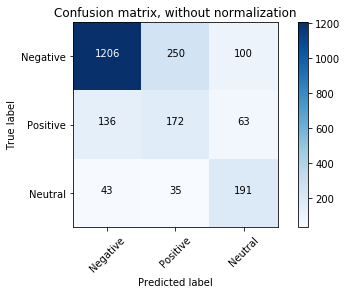

Confusion Matrix for the second model, without outliers 

[[1000  134   49]
 [  70  105   27]
 [  33   12  133]]


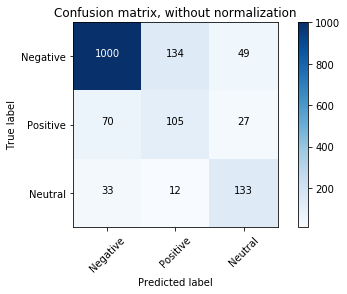

In [22]:
print 'Confusion Matrix for the first Model \n'
cnf_matrix1 = confusion_matrix(pred1, main_dataset['test']['y'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=['Negative','Positive','Neutral'],
                      title='Confusion matrix, without normalization')
plt.show()

print 'Confusion Matrix for the second model, without outliers \n'

cnf_matrix2 = confusion_matrix(pred2, aux_dataset['test']['y'])
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=['Negative','Positive','Neutral'],
                      title='Confusion matrix, without normalization')
plt.show()


Confusion Matrix for the third model, parsing the text of the tweet: 

[[1099  180   82]
 [ 252  238   74]
 [  50   37  184]]


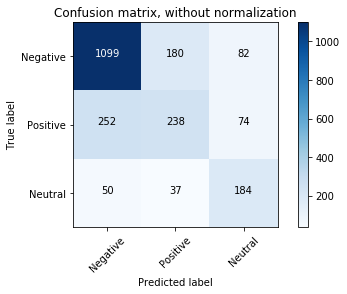

In [23]:
print 'Confusion Matrix for the third model, parsing the text of the tweet: \n'

cnf_matrix_wp = confusion_matrix(pred_parse, dataset_wp['test']['y'])
plt.figure()
plot_confusion_matrix(cnf_matrix_wp, classes=['Negative','Positive','Neutral'],
                      title='Confusion matrix, without normalization')
plt.show()


## Sentiment Analyisis

Let's try now a bit of **sentiment analysis**. We can get a lot of useful information about the sentiment of a tweet by analyzing the emojis that can be found in them. Let's try to create a model with the ability to capture emojis. We will define 2 functions in order to prepocess data:
1. **Function1 - Capture Emojis**: A function to capture the emojis in the text, that will remove from the text everthing that isn't an emoji.
2. **Function2 - Capture userwriten emojis**. We will try to capture with these function emojis like: ":)", ":("...

In [24]:
em = re.compile(r'(\xf0\S*)')
rep = re.compile("[\uD800-\uDFFF]", re.UNICODE)
def prep_func(s):
    aux = []
    emojis = em.findall(s)
    for elem in emojis:
        elem = rep.sub('', elem)
        while len(elem) > 4:
            aux.append(elem[0:4])
            elem = elem[4:]
        aux.append(elem)
    return ','.join(aux)
df['emojis'] = df.apply(lambda x: prep_func(x.text), axis = 1)

In [25]:
dataset_em = obtain_data_representation_emojis(df, show_modelwords=True)

('Words for the model are: ', [u'agent', u'airline', u'airlines', u'airport', u'americanair', u'bad', u'bag', u'baggage', u'bags', u'best', u'better', u'book', u'booked', u'cancelled', u'care', u'change', u'check', u'connection', u'crew', u'customer', u'customers', u'day', u'days', u'delay', u'delayed', u'delays', u'didn', u'doesn', u'don', u'email', u'experience', u'flightled', u'flying', u'follow', u'gate', u'going', u'good', u'great', u'guys', u'help', u'hold', u'home', u'hope', u'hotel', u'hour', u'hours', u'hrs', u'info', u'issue', u'jetblue', u'just', u'know', u'late', u'left', u'like', u'long', u'lost', u'love', u'luggage', u'miles', u'min', u'minutes', u'miss', u'nice', u'night', u'number', u'online', u'passengers', u'people', u'phone', u'plane', u'problems', u'really', u'reservation', u'response', u'seat', u'seats', u'service', u'sitting', u'southwestair', u'staff', u'stuck', u'sure', u'thank', u'thanks', u'ticket', u'time', u'times', u'today', u'told', u'tomorrow', u'tonight'

The score achieved by the model trained with the full training data including emojis is: 0.675774
Confusion Matrix for the fourth model, including emojis in the text of the tweet: 

[[983 114  51]
 [286 284  72]
 [129  60 217]]


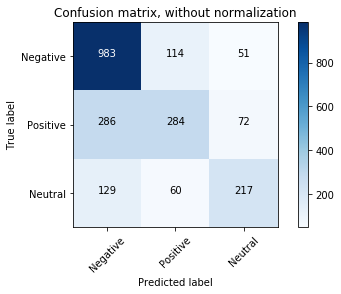

In [28]:
clf_em = BernoulliNB()
clf_em.fit(dataset_em['train']['x'], dataset_em['train']['y'])

pred_em = clf_em.predict(dataset_em['test']['x'])
print 'The score achieved by the model trained with the full training data including emojis is: %2.6f' % (accuracy_score(dataset_em['test']['y'], pred_em))

print 'Confusion Matrix for the fourth model, including emojis in the text of the tweet: \n'

cnf_matrix_em = confusion_matrix(pred_em, dataset_em['test']['y'])
plt.figure()
plot_confusion_matrix(cnf_matrix_em, classes=['Negative','Positive','Neutral'],
                      title='Confusion matrix, without normalization')
plt.show()


In [29]:
# Para el DictVectorizer
#[Counter(s.split()) for s in samples]

## Adding numerical features to predict with other classifiers.

Now, we'll create two separate models to see if our predictions are improved in some way. The first model will predict values based on the text of the tweet and the second one, on the airline, the retweet count and the date. But as we cannot feed the pure dates into our ML model, we'll do some feature engineering first:
- Create some useful such us day_of_week, day_of_month, day_of_year
- We have seen that something weird happenned on the 23rd of February of 2015 there was a great amount of people that tweeted with a negative sentiment, so we'll create a bool variable that will indicate wether the tweet has been issued on this day.

Al the things mentioned above will be done in the function: **dealwith_dates**

In [30]:
# df = dealwith_dates(df)
# dfaux = dealwith_dates(dfaux)
# main_df = obtain_data_representation2(df)
# aux_df = obtain_data_representation2(dfaux)

Now, let's try the linear **regression model**:

In [31]:
'''from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
main_df['num']['train']['x'] = scaler1.fit_transform(main_df['num']['train']['x'])
main_df['num']['test']['x'] = scaler1.transform(main_df['num']['test']['x'])

aux_df['num']['train']['x'] = scaler2.fit_transform(aux_df['num']['train']['x'])
aux_df['num']['test']['x'] = scaler2.transform(aux_df['num']['test']['x'])

clf_num1 = RandomForestClassifier()
clf_num1.fit(main_df['num']['train']['x'], main_df['num']['train']['y'])
clf_num2 = RandomForestClassifier()
clf_num2.fit(aux_df['num']['train']['x'], aux_df['num']['train']['y'])

pred_num1 = clf_num1.predict(main_df['num']['test']['x'])
pred_num2 = clf_num2.predict(aux_df['num']['test']['x'])
print 'The score achieved by the model trained with the full training data is: %2.6f' % (accuracy_score(main_df['num']['test']['y'], pred_num1))
print '---------------------------------------------- \n'
print 'The score achieved by the model trained with the filtered training data is: %2.6f' % (accuracy_score(aux_df['num']['test']['y'], pred_num2)), '\n'


print 'Confusion Matrix for the first Model \n'
cnf_matrix_num1 = confusion_matrix(pred_num1, main_df['num']['test']['y'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_num1, classes=['Negative','Positive','Neutral'],
                      title='Confusion matrix, without normalization')
plt.show()

print 'Confusion Matrix for the second model, without outliers \n'

cnf_matrix_num2 = confusion_matrix(pred_num2, aux_df['num']['test']['y'])
plt.figure()
plot_confusion_matrix(cnf_matrix_num2, classes=['Negative','Positive','Neutral'],
                      title='Confusion matrix, without normalization')
plt.show()'''


"from sklearn.ensemble import RandomForestClassifier\nfrom sklearn.preprocessing import MinMaxScaler\nscaler1 = MinMaxScaler()\nscaler2 = MinMaxScaler()\nmain_df['num']['train']['x'] = scaler1.fit_transform(main_df['num']['train']['x'])\nmain_df['num']['test']['x'] = scaler1.transform(main_df['num']['test']['x'])\n\naux_df['num']['train']['x'] = scaler2.fit_transform(aux_df['num']['train']['x'])\naux_df['num']['test']['x'] = scaler2.transform(aux_df['num']['test']['x'])\n\nclf_num1 = RandomForestClassifier()\nclf_num1.fit(main_df['num']['train']['x'], main_df['num']['train']['y'])\nclf_num2 = RandomForestClassifier()\nclf_num2.fit(aux_df['num']['train']['x'], aux_df['num']['train']['y'])\n\npred_num1 = clf_num1.predict(main_df['num']['test']['x'])\npred_num2 = clf_num2.predict(aux_df['num']['test']['x'])\nprint 'The score achieved by the model trained with the full training data is: %2.6f' % (accuracy_score(main_df['num']['test']['y'], pred_num1))\nprint '------------------------------

In [32]:
# main_df['num']['train']['x']

##### XGBOOST

The xgboost model will be used in the first place to create a first prediction. Two models will be created that will use (in the first place) the same parameters, to see whether it is better to train the model with the corrected data, or with the full dataset

In [36]:
import xgboost as xgb
xgb_params = {
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'binary:logistic',
    'silent': 1
}

ImportError: No module named xgboost

In [34]:
gbm1 = xgb.XGBClassifier()
gbm2 = xgb.XGBClassifier()
# gbm.fit(dataset['train']['x'], dataset['train']['y'],eval_set=[(dataset['train']['x'], dataset['train']['y']), (dataset['test']['x'], dataset['test']['y'])], eval_metric='logloss', verbose=True)

gbm1.fit(main_dataset['train']['x'], main_dataset['train']['y'])
gbm2.fit(aux_dataset['train']['x'], aux_dataset['train']['y'])
gbm3.fit(dataset_em['train']['x'], dataset_em['train']['y'])

pred1 = gbm1.predict(main_dataset['test']['x'])
pred2 = gbm2.predict(aux_dataset['test']['x'])
pred3 = gbm3.predict(dataset_em['test']['x'])

NameError: name 'xgb' is not defined

In [27]:
print 'The score achieved by the model trained with the full training data is: %2.6f' % (accuracy_score(main_dataset['test']['y'], pred1)), '\n'
print '---------------------------------------------- \n'
print 'The score achieved by the model trained with the filtered training data is: %2.6f' % (accuracy_score(aux_dataset['test']['y'], pred2)), '\n'


The score achieved by the model trained with the full training data is: 0.739071 

---------------------------------------------- 

The score achieved by the model trained with the filtered training data is: 0.808061 



### Tuning the parameters

In [8]:
'''from xgboost.sklearn import XGBClassifier
from sklearn.grid_search import GridSearchCV 

xgb_model = XGBClassifier(other_params)

test_params = {
 'max_depth':[4,8,12]
}

model = GridSearchCV(estimator = xgb_model,param_grid = test_params)
model.fit(train,target)
print model.best_params_'''

"from xgboost.sklearn import XGBClassifier\nfrom sklearn.grid_search import GridSearchCV \n\nxgb_model = XGBClassifier(other_params)\n\ntest_params = {\n 'max_depth':[4,8,12]\n}\n\nmodel = GridSearchCV(estimator = xgb_model,param_grid = test_params)\nmodel.fit(train,target)\nprint model.best_params_"

## Get output

In [22]:
'''import datetime

def create_submit_file(df_submission, ypred):
    date = datetime.datetime.now().strftime("%m_%d_%Y")
    filename = 'submission_' + date + '.csv'
    
    df_submission['airline_sentiment'] = ypred
    df_submission[['airline_sentiment']].to_csv(filename)
    
    print('Submission file created: {}'.format(filename))
    print('Upload it to Kaggle InClass')

    
# Read submission and retrain with whole data
df_submission = pd.read_csv('tweets_submission.csv', index_col='tweet_id')
# We use df_submision as test, otherwise it would split df in train/test
submission_dataset = obtain_data_representation(df, df_submission)

print 'The shape of the testing dataset is: (%i, %i)' % (df_submission.shape), '\n'

print submission_dataset
predictions = clf.predict(submission_dataset['test']['x'])
# Create submission file with obtained y_pred
create_submit_file(df_submission, predictions)'''

'import datetime\n\ndef create_submit_file(df_submission, ypred):\n    date = datetime.datetime.now().strftime("%m_%d_%Y")\n    filename = \'submission_\' + date + \'.csv\'\n    \n    df_submission[\'airline_sentiment\'] = ypred\n    df_submission[[\'airline_sentiment\']].to_csv(filename)\n    \n    print(\'Submission file created: {}\'.format(filename))\n    print(\'Upload it to Kaggle InClass\')\n\n    \n# Read submission and retrain with whole data\ndf_submission = pd.read_csv(\'tweets_submission.csv\', index_col=\'tweet_id\')\n# We use df_submision as test, otherwise it would split df in train/test\nsubmission_dataset = obtain_data_representation(df, df_submission)\n\nprint \'The shape of the testing dataset is: (%i, %i)\' % (df_submission.shape), \'\n\'\n\nprint submission_dataset\npredictions = clf.predict(submission_dataset[\'test\'][\'x\'])\n# Create submission file with obtained y_pred\ncreate_submit_file(df_submission, predictions)'

In [23]:
# df_submission